# 1. Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

In [2]:
# Configuration for plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load the dataset
# Make sure the file 'CreditCard_STM.csv' is in the same directory
df = pd.read_csv('CreditCard_STM.csv')

# Drop ID columns as they are not useful for clustering
if 'CUST_ID' in df.columns:
    df = df.drop(['CUST_ID'], axis=1)
if 'Unnamed: 0' in df.columns:
    df = df.drop(['Unnamed: 0'], axis=1)

print("Data Loaded Successfully.")
print(f"Shape: {df.shape}")
df.head()

Data Loaded Successfully.
Shape: (8800, 17)


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,908.354652,1.000000,231.35,0.00,231.35,944.183414,1.000000,0.000000,0.857143,0.142857,3,7,1000.0,161.975360,930.115009,0.0,7
1,744.083484,1.000000,1096.98,589.48,507.50,174.714236,1.000000,0.500000,0.600000,0.200000,4,14,5000.0,1873.388189,148.294074,0.1,10
2,738.067431,1.000000,752.97,752.97,0.00,0.000000,0.666667,0.666667,0.000000,0.000000,0,11,2500.0,1393.051729,282.663936,0.0,12
3,333.085021,0.636364,980.00,980.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1000.0,1485.205378,163.396716,0.0,12
4,3559.634883,1.000000,7654.81,6984.29,670.52,0.000000,0.666667,0.666667,0.333333,0.000000,0,45,7000.0,2785.055072,783.737906,0.0,12


# 2. Exploratory Data Analysis

Missing Values:
 BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    305
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64


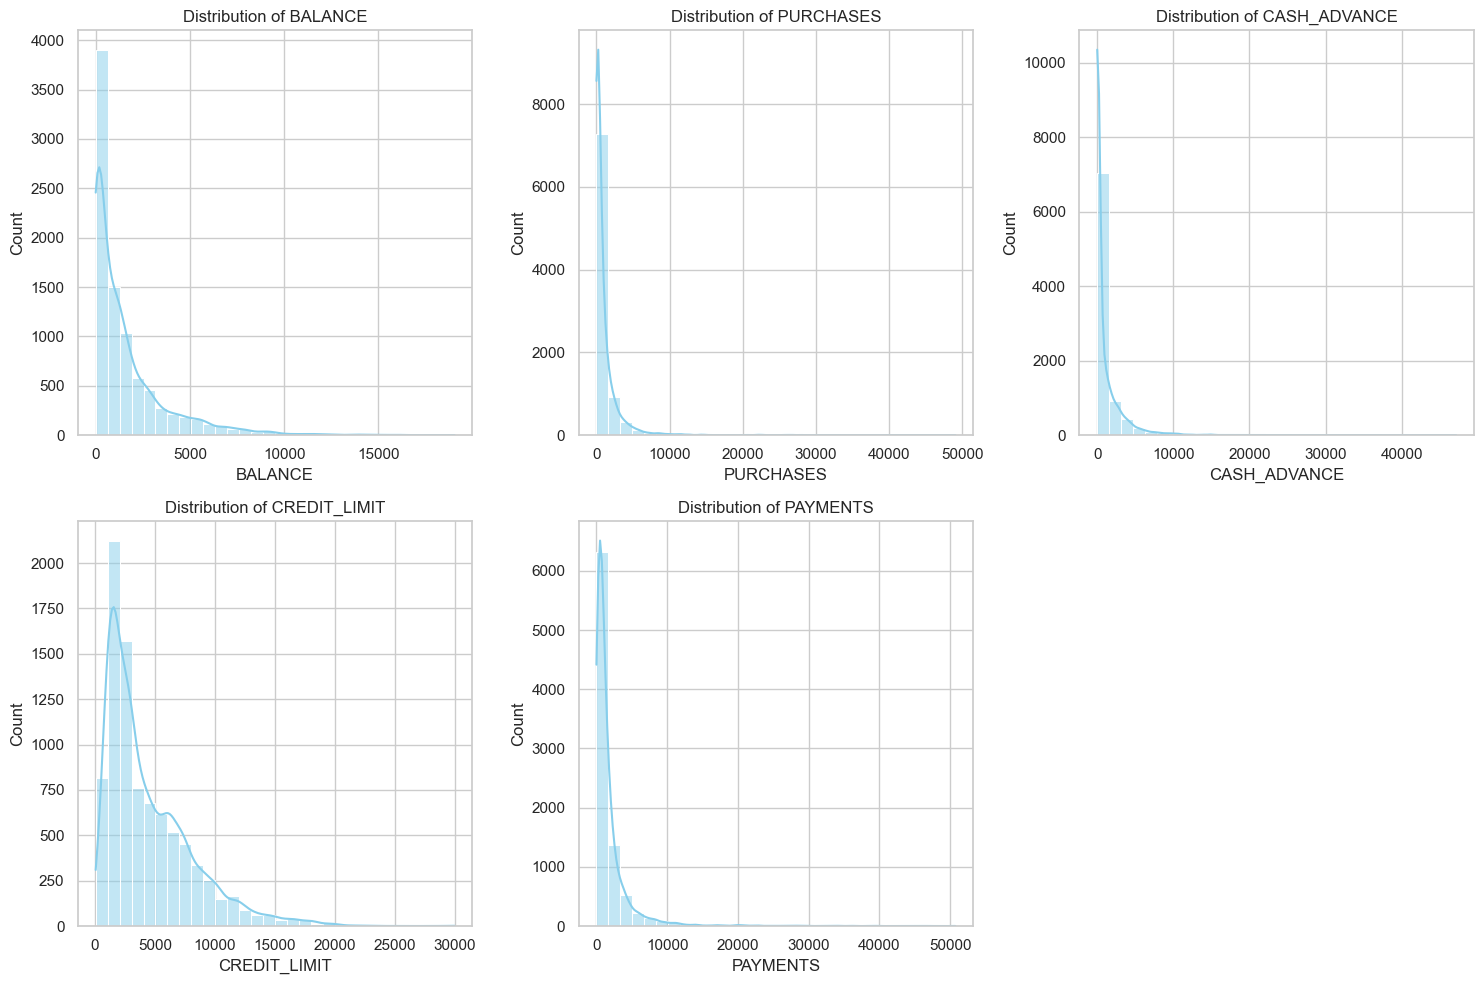

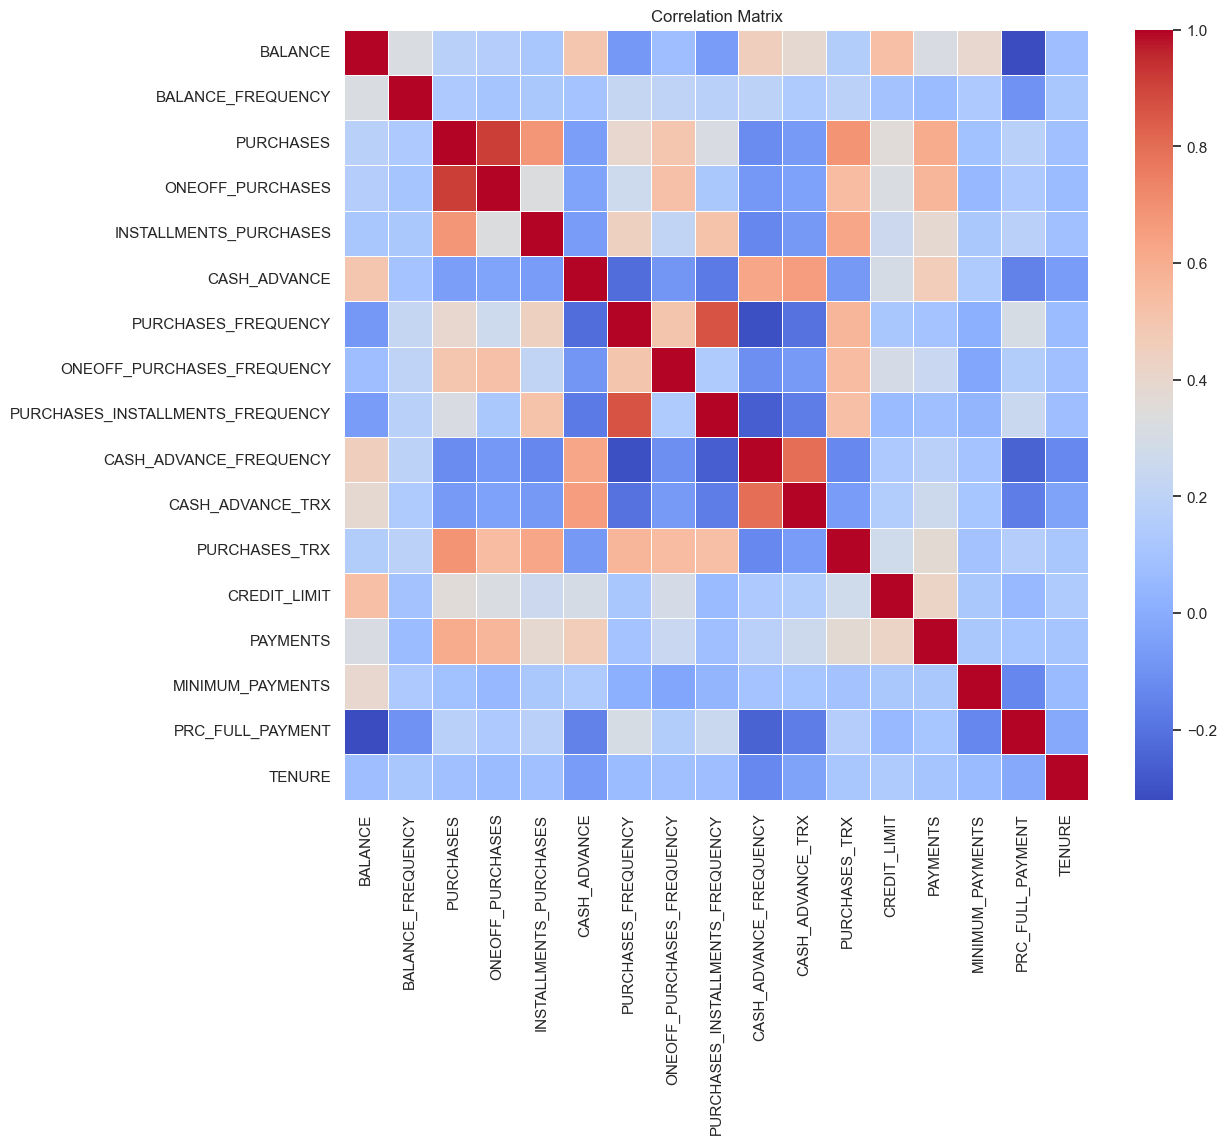

Observation: Data is highly skewed (right-skewed). Scaling is mandatory before Clustering.


In [3]:
# 1. Missing Values Analysis
print("Missing Values:\n", df.isnull().sum())

# Impute missing values with Median (Robust to outliers)
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# 2. Distribution Plots
# We plot histograms for a few key features to understand the skewness
features_to_plot = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS']

plt.figure(figsize=(15, 10))
for i, col in enumerate(features_to_plot):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_imputed[col], bins=30, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# 3. Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df_imputed.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

print("Observation: Data is highly skewed (right-skewed). Scaling is mandatory before Clustering.")

# 3. Preprocessing and Finding Optimal K

We use the Elbow Method to determine the right number of segments.

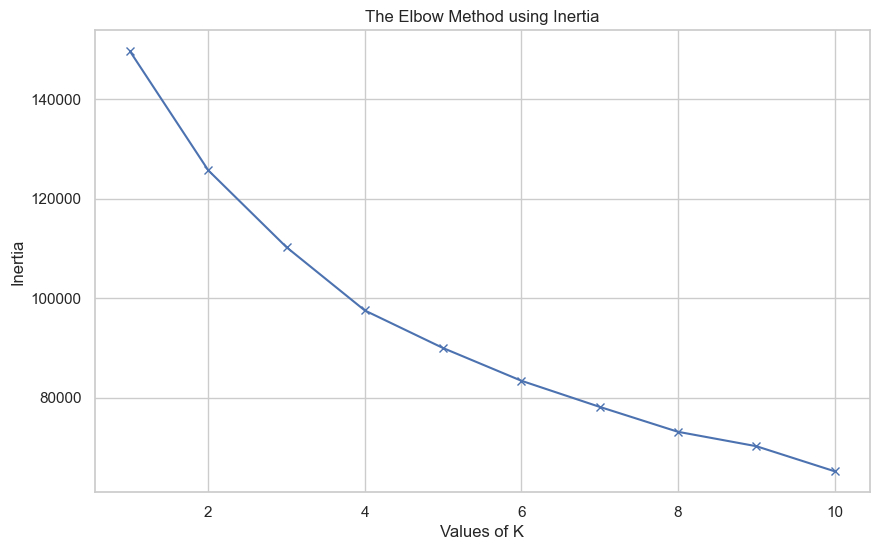

Analysis: The elbow occurs around K=4 or K=5. We will proceed with K=4 for distinct business segments in order to keep a more simple project, as simplicity is often linked to more robustness.


In [5]:
# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputed)

# Elbow Method to find optimal K
inertia = []
range_values = range(1, 11)

for i in range_values:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range_values, inertia, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

print("Analysis: The elbow occurs around K=4 or K=5. We will proceed with K=4 for distinct business segments in order to keep a more simple project, as simplicity is often linked to more robustness.")

# 4. Building the Segmentation Model (K-Means)

In [6]:
# Fit K-Means with optimal K=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to original data
df_clustered = df_imputed.copy()
df_clustered['CLUSTER'] = clusters

print("Clustering completed. Cluster counts:")
print(df_clustered['CLUSTER'].value_counts())

Clustering completed. Cluster counts:
CLUSTER
0    3895
1    3322
2    1186
3     397
Name: count, dtype: int64


# 5. Statistical Analysis of Clusters

Cluster Profiles (Mean Values):


,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS,PRC_FULL_PAYMENT
CLUSTER,,,,,,,,
0,1007.727195,268.793186,208.928272,60.137489,591.337083,3271.412923,972.573970,0.078267
1,893.043992,1236.963606,594.186132,643.055403,206.747824,4214.379968,1331.936779,0.270615
2,4589.266499,502.390624,320.451155,182.025194,4491.186984,7543.637897,3491.802479,0.034943
3,3533.827441,7697.784710,5103.729043,2595.567003,657.935867,9720.906801,7194.689593,0.286433


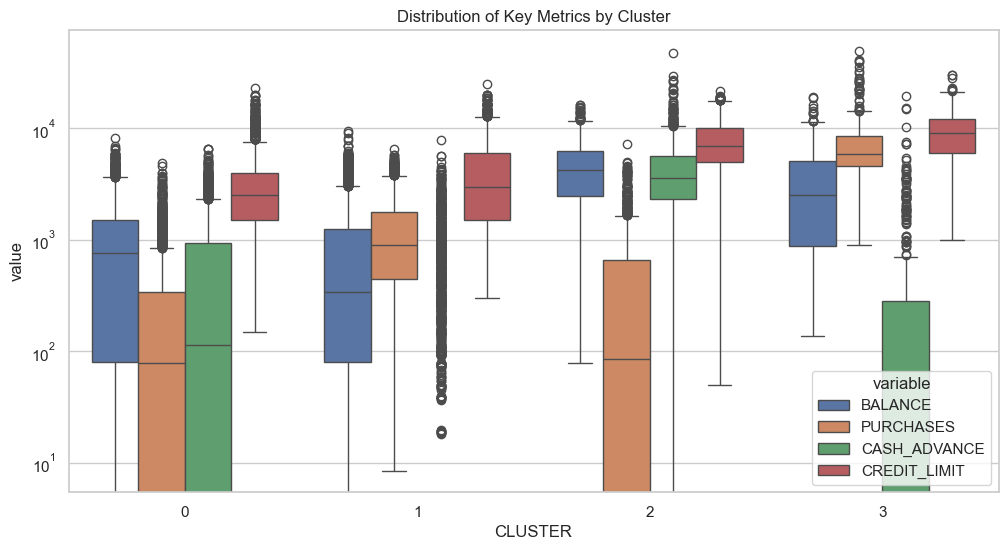

In [7]:
# Calculate mean of features for each cluster
cluster_summary = df_clustered.groupby('CLUSTER').mean()

# Let's highlight key differentiating features
key_features = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 
                'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'PRC_FULL_PAYMENT']

print("Cluster Profiles (Mean Values):")
display(cluster_summary[key_features].style.background_gradient(cmap='coolwarm'))

# Visualizing the differences using Boxplots
# We normalize data just for visualization to compare scales
df_melted = pd.melt(df_clustered, id_vars=['CLUSTER'], value_vars=['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT'])

plt.figure(figsize=(12, 6))
sns.boxplot(x='CLUSTER', y='value', hue='variable', data=df_melted)
plt.title('Distribution of Key Metrics by Cluster')
plt.yscale('log') # Log scale to handle skewness
plt.show()

# 6. Defining Segments and Credit Limit Strategy

In [8]:
# AUTOMATED MAPPING LOGIC (To ensure code robustness even if labels swap)
# We identify clusters based on their characteristics relative to the dataset mean

mean_purchases = df_clustered['PURCHASES'].mean()
mean_cash = df_clustered['CASH_ADVANCE'].mean()
mean_balance = df_clustered['BALANCE'].mean()

def identify_cluster_type(row_mean):
    if row_mean['PURCHASES'] > mean_purchases * 2:
        return "VIP / Big Spenders"
    elif row_mean['CASH_ADVANCE'] > mean_cash * 2:
        return "Cash Advancers"
    elif row_mean['BALANCE'] > mean_balance and row_mean['PURCHASES'] < mean_purchases:
        return "High Balance / Revolvers"
    else:
        return "Low Activity / Frugal"

# Apply names
cluster_names = {}
for cluster_id in range(4):
    row_stats = cluster_summary.loc[cluster_id]
    name = identify_cluster_type(row_stats)
    cluster_names[cluster_id] = name

print("Segment Definitions determined by logic:", cluster_names)

# Define Credit Limit Logic
def recommend_credit_limit(row, cluster_name):
    current_limit = row['CREDIT_LIMIT']
    
    if cluster_name == "VIP / Big Spenders":
        # Strategy: Increase limit to encourage spending. 
        # Cap at 150% of current limit or significant usage multiple
        return max(current_limit * 1.5, row['PURCHASES'] * 3)
        
    elif cluster_name == "Cash Advancers":
        # Strategy: Riskier segment. Keep limit strictly controlled.
        # Limit exposure to slightly above their current balance
        return max(current_limit, row['BALANCE'] * 1.1)
        
    elif cluster_name == "High Balance / Revolvers":
        # Strategy: High debt ratio. Do not increase limit significantly to prevent default.
        return current_limit
        
    elif cluster_name == "Low Activity / Frugal":
        # Strategy: Low engagement. Moderate limit to encourage usage but low risk.
        return max(1500, current_limit)
    
    return current_limit

# Apply strategy
df_clustered['SEGMENT_NAME'] = df_clustered['CLUSTER'].map(cluster_names)
df_clustered['RECOMMENDED_LIMIT'] = df_clustered.apply(lambda x: recommend_credit_limit(x, x['SEGMENT_NAME']), axis=1)

print("\nSample Recommendations:")
print(df_clustered[['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'SEGMENT_NAME', 'RECOMMENDED_LIMIT']].head(10))

Segment Definitions determined by logic: {0: 'Low Activity / Frugal', 1: 'Low Activity / Frugal', 2: 'Cash Advancers', 3: 'VIP / Big Spenders'}

Sample Recommendations:
       BALANCE  PURCHASES  CREDIT_LIMIT           SEGMENT_NAME  \
0   908.354652     231.35        1000.0  Low Activity / Frugal   
1   744.083484    1096.98        5000.0  Low Activity / Frugal   
2   738.067431     752.97        2500.0  Low Activity / Frugal   
3   333.085021     980.00        1000.0  Low Activity / Frugal   
4  3559.634883    7654.81        7000.0     VIP / Big Spenders   
5   649.566721     245.77        3000.0  Low Activity / Frugal   
6   962.855497    1839.69        5000.0  Low Activity / Frugal   
7  1328.569532     140.00        1600.0  Low Activity / Frugal   
8  1961.246269       0.00        2000.0  Low Activity / Frugal   
9  3718.606699    1172.68        9500.0         Cash Advancers   

   RECOMMENDED_LIMIT  
0            1500.00  
1            5000.00  
2            2500.00  
3           

# 7. Robustness Analysis

In [9]:
from sklearn.metrics import silhouette_score

# 1. Silhouette Score (Internal Validation)
sil_score = silhouette_score(X_scaled, clusters, sample_size=1000)
print(f"Silhouette Score (Full Model): {sil_score:.3f}")

# 2. Stability Check (Split validation)
# We split data, fit on one half, and check if centroids are similar to original
sample_indices = np.random.choice(len(X_scaled), size=int(len(X_scaled)*0.7), replace=False)
X_sample = X_scaled[sample_indices]

kmeans_sample = KMeans(n_clusters=4, random_state=99, n_init=10)
kmeans_sample.fit(X_sample)

print("\nOriginal Centroids (First Feature - Balance):")
print(np.sort(kmeans.cluster_centers_[:, 0]))
print("\nSample Run Centroids (First Feature - Balance):")
print(np.sort(kmeans_sample.cluster_centers_[:, 0]))

print("\nComment: If the centroid values for key features are similar between the full run and the sample run, the clustering is robust.")

Silhouette Score (Full Model): 0.198

Original Centroids (First Feature - Balance):
[-0.32158547 -0.26637899  0.94964135  1.4577112 ]

Sample Run Centroids (First Feature - Balance):
[-0.32089877 -0.23770132  0.98022793  1.55632982]

Comment: If the centroid values for key features are similar between the full run and the sample run, the clustering is robust.


# 8. Assigning New Customers

We generate 150 random customers based on the dataset's distribution and assign them segments.

In [10]:
# Generate synthetic data based on column means and stds
np.random.seed(101)
new_customers_data = {}

for col in df_imputed.columns:
    if col not in ['CLUSTER', 'SEGMENT_NAME', 'RECOMMENDED_LIMIT']:
        mu = df_imputed[col].mean()
        sigma = df_imputed[col].std()
        # Generate, ensuring no negative values for financial metrics
        new_customers_data[col] = np.abs(np.random.normal(mu, sigma, 150))

new_df = pd.DataFrame(new_customers_data)

# Preprocess new data using the SAME scaler trained on original data
new_X_scaled = scaler.transform(new_df)

# Predict Cluster
new_clusters = kmeans.predict(new_X_scaled)
new_df['CLUSTER'] = new_clusters
new_df['SEGMENT_NAME'] = new_df['CLUSTER'].map(cluster_names)

# Assign Limits
new_df['RECOMMENDED_LIMIT'] = new_df.apply(lambda x: recommend_credit_limit(x, x['SEGMENT_NAME']), axis=1)

print("New Customers Assigned:")
display(new_df['SEGMENT_NAME'].value_counts())
display(new_df.head())

# Save the model and scaler for the dashboard
import joblib
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
# Save the cluster logic mapping for the app
joblib.dump(cluster_names, 'cluster_names.pkl') 
print("Models saved for Dashboard.")

New Customers Assigned:


SEGMENT_NAME
Low Activity / Frugal    121
Cash Advancers            28
VIP / Big Spenders         1
Name: count, dtype: int64

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,CLUSTER,SEGMENT_NAME,RECOMMENDED_LIMIT
0,7184.484578,0.647747,2034.951789,1101.700396,636.072602,4786.504596,0.706520,0.496490,0.528838,0.054123,9.543875,28.968081,1112.564326,490.578433,1714.800595,0.349914,12.884879,2,Cash Advancers,7902.933036
1,2866.015504,0.517405,1688.135094,1473.448893,716.967413,2392.282766,0.099044,0.150846,0.126509,0.270167,2.442760,58.899978,3948.535040,3030.049244,334.914333,0.197795,10.685628,0,Low Activity / Frugal,3948.535040
2,3447.367473,1.145773,3153.058431,18.387066,397.996513,159.143823,0.772740,0.042254,0.347703,0.130765,2.446965,26.510503,16284.889120,1196.465045,4118.642296,0.808270,11.363893,1,Low Activity / Frugal,16284.889120
3,2607.771738,1.002519,1705.492176,1568.372411,801.287319,4152.832779,1.113244,0.480442,0.340340,0.315170,4.002995,45.211572,5777.089364,2627.425744,2005.759025,0.129926,12.281213,1,Low Activity / Frugal,5777.089364
4,2913.766611,0.970645,2967.612322,4938.234476,158.096184,1285.226746,1.356376,0.532405,0.878090,0.047253,6.811706,42.962592,4402.988341,1610.008564,3214.022233,0.140631,11.451701,1,Low Activity / Frugal,4402.988341


Models saved for Dashboard.
